### Многопоточность. Часть 1.

<br />

##### Процессы и потоки

Чёткого и понятного определения процессов и потоков найти не удалось. Их будем понимать постепенно.

https://en.wikipedia.org/wiki/Thread_(computing)
    
>  **thread of execution** is the smallest <u>sequence of</u> programmed <u>instructions</u> that can be managed independently by a <u>scheduler</u>, which is typically a part of the <u>operating system</u>

Таненбаум, Современные операционные системы, гл. 2:

> **Процесс** - абстракция, описывающая выполняющуюся программу

https://en.wikipedia.org/wiki/Process_(computing)

> **process** is the <u>instance of a computer program</u> that is being executed by one or many threads.

Процессы управляются ОС.

<br />

Типичная программа из одного потока:

```c++
#include <cstdio>

int main() {
    std::puts("hello world!\n");
    return 0;
}
```

Скомпилируем её и запустим:

```bash
$ ./hello_world.exe  # здесь ОС порождает процесс, который запускает 1 поток, в конце поток умирает, умирает процесс
hello world!
$ ./hello_world.exe  # здесь ОС порождает процесс, который запускает 1 поток, в конце поток умирает, умирает процесс
hello world!
$ ./hello_world.exe  # здесь ОС порождает процесс, который запускает 1 поток, в конце поток умирает, умирает процесс
hello world!

# запущенный терминал - тоже процесс
# параллельно запущенный терминал - другой процесс
```

**Замечание:** Это определение для процессов корректно для простеньких программ. В 2020+ гг. серьёзные приложения уже используют несколько процессов. Показать Диспетчер Задач и процессы в нём, показать `htop`, `ps`, `pgrep`, запустить `vim` параллельно, найти его в `htop`, показать что такой процесс есть.

<br />

Поток, который выполняет `main`, называется **главным**.

Любой поток (в том числе главный) может порождать другие потоки. Выглядит это примерно так:

```c++

#include <cstdio>

void print_hello_world()
{
    std::puts("hello world!\n");
}

void thread_worker()
{
    print_hellow_world();
    print_hellow_world();
    print_hellow_world();
}

int main() {
    std::puts("hello world!\n");
    
    // Псевдокод:
    CREATE THREAD TO RUN (thread_worker);
    CREATE THREAD TO RUN (thread_worker);
    CREATE THREAD TO RUN (print_hello_world);
    ...
    
    return 0;
}

```

Вопросы для обсуждения:
* сколько `main`-ов в одном процессе? В одном потоке? Во всех потоках одного процесса?
* память в процессах и потоках?
* как передавать данные между потоками? между процессами?
* сколько стеков в многопоточном приложении?
* что такое context switch?
* сколько процессов может быть у одного приложения?

![](processes_threads_3.jpg)

<br />

##### Потоки. std::thread basics

Потоки стандартной библиотеки (since C++11):

https://en.cppreference.com/w/cpp/thread/thread

Как пользоваться:

```c++
#include <iostream>
#include <thread>

int main()
{
    // create thread with function to execute
    std::thread thr([](){
        std::cout << "hello";
        std::cout << " ";
        std::cout << "world!";
        std::cout << std::endl;
    });
    
    std::cout << "run, Forest, run!" << std::endl;
    std::cout << "run, Forest, run!" << std::endl;
    
    return 0;
}

// Обсудить:
//    1. когда поток начнёт выполнение?
//       если быть точным: Threads begin execution immediately upon construction of the associated thread object
//                         __(pending any OS scheduling delays)__
//    2. кто видит ошибку? как часто она проявляется?
```

<details>
<summary>ответ</summary>
<p>
    
Если вызывается деструктор `thr`, а поток не закончил или даже не начинал выполнение, будет вызван `std::terminate` и процесс умрёт.

Формально спецификация не знает, чего хочет программист от конкретного потока до того как будет протрачен доступ до него в `std::~thread`, и задача программиста - явно указать.

</p>
</details>

Есть 2 варианта поведения потока до деструктора:
* `join` - дождаться завершения потока
* `detach` - отпустить выполнение потока в свободное плавание

<br />

Вариант решения:

```c++
#include <iostream>
#include <thread>

int main()
{
    // create thread with function to execute
    std::thread thr([](){
        std::cout << "hello";
        std::cout << "_";
        std::cout << "world!";
        std::cout << std::endl;
    });

    std::cout << "run, Forest, run!" << std::endl;
    
    // wait for thr to complete its job
    thr.join();
    
    std::cout << "run, Forest, run!" << std::endl;

    return 0;
}

// Обсудить: какой вывод здесь возможен?
```

```sh
hellorun, Forest, run!_world!

run, Forest, run!
```

```sh
hello_world!
run, Forest, run!
run, Forest, run!
```

Другой вариант решения:

```c++
#include <iostream>
#include <thread>

int main()
{
    // create thread with function to execute
    std::thread thr([](){
        std::cout << "hello";
        std::cout << " ";
        std::cout << "world!";
        std::cout << std::endl;
    });

    std::cout << "run, Forest, run!" << std::endl;

    // make |thr| do not own resource, let it be
    thr.detach();

    std::cout << "run, Forest, run!" << std::endl;

    return 0;
}

// Обсудить: какой вывод здесь возможен?
```

Вообще говоря, возможен и такой вывод:

```sh
run, Forest, run!
hellorun, Forest, run!
 world!
world!
```

Обсудить, почему

<br />

Ещё пример:

```c++
#include <iostream>
#include <thread>
#include <vector>

int main()
{
    std::vector<std::thread> threads;
    for (int i = 0; i < 5; ++i)
    {
        threads.emplace_back([](){
            std::cout << "hello world!" << std::endl;
        });
    }

    for (auto& thread : threads)
        thread.join();

    return 0;
}
```

Возможный вывод:

```sh
hello world!
hello world!
hello world!hello world!

hello world!
```

<br />

##### Параллельные вычисления: накладные расходы

Рассмотрим задачу: параллельный поиск максимума в массиве

Для начала узнаем, сколько на машинке ядер. В С++ это можно сделать через функцию `std::thread::hardware_concurrency`:

```c++
#include <iostream>
#include <thread>
 
int main()
{
    const unsigned int n = std::thread::hardware_concurrency();
    std::cout << "threads count: " << n << std::endl;
    return 0;
}
```

Вывод:
    
```sh
threads count: 6
```

<br />

Теперь будем в параллель искать максимум.

(код построен на измерялке `sltbench`, но можно и построить на google benchmark, отличий мало)

__Замечание__: код намеренно содержит ошибку для простоты, он некорректно обрабатывает хвосты массива, если размер не делится на число потоков.

```c++
#include <sltbench/Bench.h>

#include <algorithm>
#include <cstdlib>
#include <iostream>
#include <thread>
#include <vector>

namespace
{
    struct Arg
    {
        unsigned array_size;
        unsigned thread_cnt;
    };

    std::ostream& operator << (std::ostream& oss, const Arg& arg)
    {
        return oss << arg.array_size << '/' << arg.thread_cnt;
    }
}

static std::vector<int> arr = [](){
    constexpr size_t BIG_SIZE = 200 * 1024 * 1024 / sizeof(int); // 200 MB of data
    std::vector<int> rv(BIG_SIZE, 0);
    for (int& x : rv)
        x = std::rand();
    return rv;
}();
    
void parallel_max(const Arg& arg)
{
    int result = 0;
    if (arg.thread_cnt == 1)
    {
        result = *max_element(begin(arr), begin(arr) + arg.array_size);
    }
    else
    {
        // maximum per threads
        std::vector<int> results(arg.thread_cnt,
                                 std::numeric_limits<int>::min());

        // create threads to search for maximum
        std::vector<std::thread> threads;
        threads.reserve(arg.thread_cnt);
        const unsigned len = arg.array_size / arg.thread_cnt;
        for (unsigned i = 0; i < arg.thread_cnt; ++i)
        {
            threads.emplace_back([i, len, &results](){
                results[i] = *max_element(begin(arr) + len * i,
                                          begin(arr) + len * (i + 1));
            });
        }

        // wait for threads to complete
        for (auto& t : threads)
            t.join();

        result = *max_element(begin(results), end(results));
    }
    sltbench::DoNotOptimize(result);
}

static const std::vector<Arg> args{
    // fixed size
    {/*array_size*/16777216, /*thread_cnt*/ 1},
    {/*array_size*/16777216, /*thread_cnt*/ 2},
    {/*array_size*/16777216, /*thread_cnt*/ 3},
    {/*array_size*/16777216, /*thread_cnt*/ 4},
    {/*array_size*/16777216, /*thread_cnt*/ 5},
    {/*array_size*/16777216, /*thread_cnt*/ 6},
    {/*array_size*/16777216, /*thread_cnt*/ 7},
    {/*array_size*/16777216, /*thread_cnt*/ 8},
    {/*array_size*/16777216, /*thread_cnt*/ 9},
    {/*array_size*/16777216, /*thread_cnt*/10},
    {/*array_size*/16777216, /*thread_cnt*/11},
    {/*array_size*/16777216, /*thread_cnt*/12},

    // fixed single thread
    {/*array_size*/     128, /*thread_cnt*/ 1},
    {/*array_size*/     256, /*thread_cnt*/ 1},
    {/*array_size*/     512, /*thread_cnt*/ 1},
    {/*array_size*/    1024, /*thread_cnt*/ 1},
    {/*array_size*/    2048, /*thread_cnt*/ 1},
    {/*array_size*/    4096, /*thread_cnt*/ 1},
    {/*array_size*/    8192, /*thread_cnt*/ 1},
    {/*array_size*/   16384, /*thread_cnt*/ 1},
    {/*array_size*/   32768, /*thread_cnt*/ 1},
    {/*array_size*/   65536, /*thread_cnt*/ 1},
    {/*array_size*/  131072, /*thread_cnt*/ 1},
    {/*array_size*/  262144, /*thread_cnt*/ 1},
    {/*array_size*/  524288, /*thread_cnt*/ 1},
    {/*array_size*/ 1048576, /*thread_cnt*/ 1},
    {/*array_size*/ 2097152, /*thread_cnt*/ 1},
    {/*array_size*/ 4194304, /*thread_cnt*/ 1},
    {/*array_size*/ 8388608, /*thread_cnt*/ 1},
    {/*array_size*/16777216, /*thread_cnt*/ 1},
    
    // fixed 4 threads
    {/*array_size*/     128, /*thread_cnt*/ 4},
    {/*array_size*/     256, /*thread_cnt*/ 4},
    {/*array_size*/     512, /*thread_cnt*/ 4},
    {/*array_size*/    1024, /*thread_cnt*/ 4},
    {/*array_size*/    2048, /*thread_cnt*/ 4},
    {/*array_size*/    4096, /*thread_cnt*/ 4},
    {/*array_size*/    8192, /*thread_cnt*/ 4},
    {/*array_size*/   16384, /*thread_cnt*/ 4},
    {/*array_size*/   32768, /*thread_cnt*/ 4},
    {/*array_size*/   65536, /*thread_cnt*/ 4},
    {/*array_size*/  131072, /*thread_cnt*/ 4},
    {/*array_size*/  262144, /*thread_cnt*/ 4},
    {/*array_size*/  524288, /*thread_cnt*/ 4},
    {/*array_size*/ 1048576, /*thread_cnt*/ 4},
    {/*array_size*/ 2097152, /*thread_cnt*/ 4},
    {/*array_size*/ 4194304, /*thread_cnt*/ 4},
    {/*array_size*/ 8388608, /*thread_cnt*/ 4},
    {/*array_size*/16777216, /*thread_cnt*/ 4},
};

SLTBENCH_FUNCTION_WITH_ARGS(parallel_max, args);

SLTBENCH_MAIN();
```

<details>
<summary>результаты</summary>
<p>

```sh
benchmark                                                   arg                      status               time(ns)
parallel_max                                                16777216/1               ok                   13341652
parallel_max                                                16777216/2               ok                    6772804
parallel_max                                                16777216/3               ok                    4542359
parallel_max                                                16777216/4               ok                    3463808
parallel_max                                                16777216/5               ok                    2818170
parallel_max                                                16777216/6               ok                    2457589
parallel_max                                                16777216/7               ok                    4069203
parallel_max                                                16777216/8               ok                    3602845
parallel_max                                                16777216/9               ok                    3228118
parallel_max                                                16777216/10              ok                    2938229
parallel_max                                                16777216/11              ok                    2779921
parallel_max                                                16777216/12              ok                    3603534
parallel_max                                                128/1                    ok                        103
parallel_max                                                256/1                    ok                        194
parallel_max                                                512/1                    ok                        378
parallel_max                                                1024/1                   ok                        744
parallel_max                                                2048/1                   ok                       1479
parallel_max                                                4096/1                   ok                       2946
parallel_max                                                8192/1                   ok                       5882
parallel_max                                                16384/1                  ok                      11770
parallel_max                                                32768/1                  ok                      23522
parallel_max                                                65536/1                  ok                      47081
parallel_max                                                131072/1                 ok                      94327
parallel_max                                                262144/1                 ok                     188814
parallel_max                                                524288/1                 ok                     378250
parallel_max                                                1048576/1                ok                     753364
parallel_max                                                2097152/1                ok                    1563725
parallel_max                                                4194304/1                ok                    3301406
parallel_max                                                8388608/1                ok                    6672297
parallel_max                                                16777216/1               ok                   13354922
parallel_max                                                128/4                    ok                      39699
parallel_max                                                256/4                    ok                      39435
parallel_max                                                512/4                    ok                      38911
parallel_max                                                1024/4                   ok                      40089
parallel_max                                                2048/4                   ok                      39912
parallel_max                                                4096/4                   ok                      40945
parallel_max                                                8192/4                   ok                      40335
parallel_max                                                16384/4                  ok                      42213
parallel_max                                                32768/4                  ok                      45452
parallel_max                                                65536/4                  ok                      49948
parallel_max                                                131072/4                 ok                      63496
parallel_max                                                262144/4                 ok                      90362
parallel_max                                                524288/4                 ok                     136073
parallel_max                                                1048576/4                ok                     234576
parallel_max                                                2097152/4                ok                     441155
parallel_max                                                4194304/4                ok                     882057
parallel_max                                                8388608/4                ok                    1733131
parallel_max                                                16777216/4               ok                    3453396
```

</p>
</details>

Посмотрим на результаты чуть подробнее:

Как растёт производительность с ростом числа потоков на большом массиве.

* Обратить внимание на поведение графика. Почему оно такое?
* Эффективность распараллеливания - насколько ускорение пропорционально числу потоков. 

In [9]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

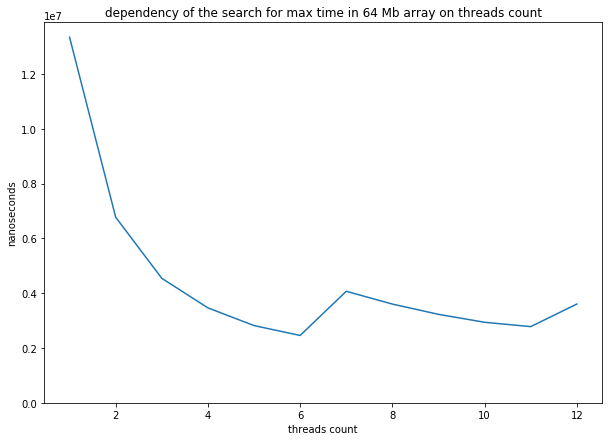

parallelization efficiency
 1 threads, eff = 1.00
 2 threads, eff = 0.98
 3 threads, eff = 0.98
 4 threads, eff = 0.96
 5 threads, eff = 0.95
 6 threads, eff = 0.90
 7 threads, eff = 0.47
 8 threads, eff = 0.46
 9 threads, eff = 0.46
10 threads, eff = 0.45
11 threads, eff = 0.44
12 threads, eff = 0.31


In [44]:
def draw_fixed_array():
    x = np.arange(12) + 1
    y = np.array([13341652, 6772804, 4542359, 3463808,
                  2818170, 2457589, 4069203, 3602845,
                  3228118, 2938229, 2779921, 3603534])
    plt.figure(figsize=(10, 7))
    plt.plot(x, y)
    plt.ylim(bottom=0)
    plt.xlabel('threads count')
    plt.ylabel('nanoseconds')
    plt.title('dependency of the search for max time in 64 Mb array on threads count')
    plt.show()
    
    print('parallelization efficiency')
    for i in range(12):
        print('{:2} threads, eff = {:.2f}'.format(x[i], (y[0] / y[i]) / x[i] ))
    

draw_fixed_array()

* обратить внимание как ведёт себя эффективность распараллеливания (насколько ускорение пропорционально числу потоков)
* что показывает эффективность распараллеливания?
* возможно ли сверхлинейное ускорение? (parallelization efficiency > 1)

Подробнее про superlinear speedup:<br />
https://en.wikipedia.org/wiki/Speedup#Super-linear_speedup

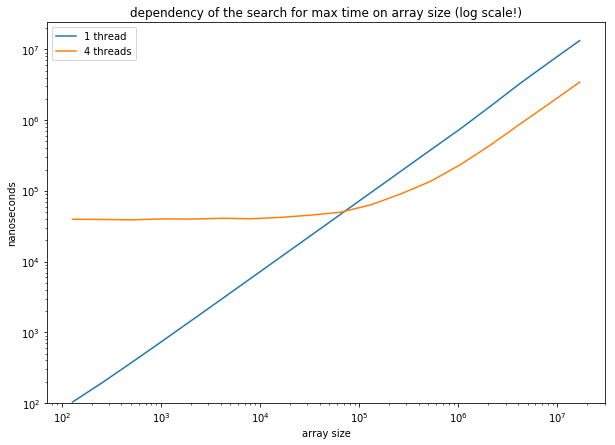

In [41]:
def draw_fixed_threads():
    x = np.array([128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152, 4194304, 8388608, 16777216])
    y_1t = np.array([103, 194, 378, 744, 1479, 2946, 5882, 11770, 23522, 47081, 94327, 188814, 378250, 753364, 1563725, 3301406, 6672297, 13354922])
    y_4t = np.array([39699, 39435, 38911, 40089, 39912, 40945, 40335, 42213, 45452, 49948, 63496, 90362, 136073, 234576, 441155, 882057, 1733131, 3453396])
    plt.figure(figsize=(10, 7))
    plt.plot(x, y_1t, label='1 thread')
    plt.plot(x, y_4t, label='4 threads')
    plt.yscale('log')
    plt.xscale('log')
    plt.ylim(bottom=100)
    plt.xlabel('array size')
    plt.ylabel('nanoseconds')
    plt.title('dependency of the search for max time on array size (log scale!)')
    plt.legend()
    plt.show()
    

draw_fixed_threads()

<br />

##### Параллельные вычисления: закон Амдала

https://ru.wikipedia.org/wiki/%D0%97%D0%B0%D0%BA%D0%BE%D0%BD_%D0%90%D0%BC%D0%B4%D0%B0%D0%BB%D0%B0

Закон Амдала формулируется в предположении, что параллельная часть алгоритма не может иметь сверхлинейного ускорения. Одна из его формулировок:

__Закон Амдала__: Пусть $T = T_0 + T_1$, где
* $T$ - время работы однопоточной версии алгоритма
* $T_0$ - время работы нераспараллеливаемой части
* $T_1$ - время работы распараллеливаемой части

Пусть $P$ - кол-во параллельных исполнителей.

Тогда время $T_P$ работы алгоритма на $P$ исполнителях:

$$T_P \ge T_0 + \frac{T_1}{P}$$

Закон Амдала очевиден чуть более чем полностью, интерес представляют скорее конкретные цифры.

__Пример__: Если $T_0 = \frac{9}{10} T$, то увеличив хоть до бесконечности число исполнителей (и бюджет), за счёт распараллеливания более чем на 10% алгоритм не ускорить.

<br />

##### std::this_thread namespace

`std::this_thread` - простарнство имён, в котором размещены функции, по смыслу относящиеся к "текущему потоку" (в рамках стека которого функции вызываются)

* `get_id` - идентификатор текущего потока
* `sleep_for` - усыпить поток на какое-то время

    ```c++
    // вариант как усыпить текущий поток как минимум на 2 секунды (может проспать дольше)
    std::this_thread::sleep_for(std::chrono::seconds(2));

    // вариант как усыпить текущий поток как минимум на 2 секунды (может проспать дольше)
    using namespace std::chrono_literals;
    std::this_thread::sleep_for(2s);
    ```

* `sleep_until` - усыпить поток до точки во времени

    ```c++
    // усыпить текущий поток как минимум до конкретной даты (может проспать дольше)
    using namespace std::chrono_literals;
    std::this_thread::sleep_until(std::chrono::system_clock::now() + 2h);
    ```
    
* `yield` - освободить фрейм выполнения потока 

    Вопросы про работу OS threads scheduler:
    * Что значит "усыпить поток"?
    * Что такое "фрейм выполнения"?
    * Когда может быть полезен yield?

    __Пример__:
    
    ```c++
    while (!is_required_event_happen())
        std::this_thread::yield();

    while (!is_another_thread_job_finished())
        std::this_thread::yield();

    // Обсудить: что будет, если не написать |yield| здесь?
    ```


<br />

##### std::thread изнутри

В реализации `std::thread` переводит свои высокоуровневые команды в вызовы к ядру ОС (потоки являются объектами ядра ОС, а пользовательской программе отдаются handle, через которые можно доступаться до объектов ядра).

* Для windows свой API управления потоками в ядре

  https://docs.microsoft.com/ru-ru/cpp/c-runtime-library/reference/beginthread-beginthreadex?view=vs-2019
  
* Для linux/osx через pthread:

  http://man7.org/linux/man-pages/man3/pthread_create.3.html


При работе с потоками, т.к. это объекты ядра ОС, происходит переход из user space в kernel space, управление отдаётся ОС. Эти переходы могут быть недешёвыми, и желательно их минимизировать.

<br />

##### std::jthread (since C++20)

https://en.cppreference.com/w/cpp/thread/jthread

`std::jthread` - развитие `std::thread` c важными "плюшками" (но и подороже в использовании):
* `jthread` можно прерывать (если быть точным - запрашивать прерывание работы потока)
* `jthread` в деструкторе ведёт себя более аккуратно:
  * прерывает выполнение
  * join-ит поток
  
Пока что документация `jthread` скуповата на примеры и описание, поэтому примеров на лекции не будет.

<br />

##### promise - future

Связка `std::promise - std::future` - один из способов передать информацию между потоками, например:
* результат выполнения потока
* нотификация о событии

По задумке `std::promise` и `std::future` являются некопируемыми, т.к. идеологически представляют собой "канал связи" с одним входом и одним выходом.

Как пользоваться:
* создаём `std::promise<T> p` с типом нужного результата (вход канала связи)
* через `auto f = p.get_future()` получаем `std::future<T>` (выход канала связи)
* в рабочем потоке по готовности:
  * либо выставляем результат через `p.set_value`
  * либо выставляем exception через `p.set_exception`
* в ожидающем потоке:
  * либо блокируемся до момента когда результат готов через `f.wait, f.get`
    * `f.wait()` - подождёт, пока чего-нибудь не выставят в `promise`
    * `T res = f.get()` - подождёт и вернёт результат либо бросит исключение, если в `promise` положили исключение
  * либо неблокирующее ожидание через `f.wait_for, f.wait_until` - методы ждут результата отведённое время, дождались или нет - определяется по коду возврата

Вариант реализации параллельного поиска максимума через связку `promise-future`:
    
```c++
int parallel_max(const std::vector<int>& arr)
{
    assert(arr.size() >= 2);  // для простоты демонстрации
    
    // функция, считающая максимум, и выставляющая результат в promise,
    // её будем вызывать в фоновых потоках
    const auto max_worker = [](std::vector<int>::const_iterator first,
                               std::vector<int>::const_iterator last,
                               std::promise<int> promise){
        const int res = *max_element(first, last);
        promise.set_value(res);
    };
    
    // заводим promise-future связки между потоками
    std::promise<int> thread_1_promise;
    std::promise<int> thread_2_promise;
    std::future<int> thread_1_future = thread_1_promise.get_future();
    std::future<int> thread_2_future = thread_2_promise.get_future();
    
    // запускаем потоки для параллельного поиска максимума
    std::thread t1(max_worker,
                   begin(arr), begin(arr) + arr.size() / 2,
                   std::move(thread_1_promise));
    std::thread t2(max_worker,
                   begin(arr) + arr.size() / 2, end(arr),
                   std::move(thread_2_promise));
    
    // дожидаемся, пока оба потока не выставят результат
    const int max_1 = thread_1_future.get();
    const int max_2 = thread_2_future.get();
    
    // дожидаемся окончания работы потоков
    // (отметьте некоторую обязательную избыточность в этом примере)
    // 
    // Вопрос: что будет, если не написать этих двух строк?
    t1.join();
    t2.join();
    
    // возвращаем результат - максимум из двух половинок
    return std::max(max_1, max_2);
}
```

__Замечание__: если фоновый поток поведёт себя некорректно и забудет выставить результат в `promise`, остаётся ещё одна выручалочка - деструктор `promise` вызовет `set_exception`, если результата нет. В нашем примере это сработает.

А в таком - нет (разобрать):

```c++
// заводим promise-future связку между потоками
std::promise<int> p;
std::future<int> f = p.get_future();

const auto worker = [&p](int x) {
    // захват promise по ссылке!
    const int res = x * x;
    // упс, мы забыли про set_value
};

// запускаем поток
std::thread t1(worker, 5);

// дожидаемся результата
const int result = f.get();  // здесь зависли навсегда

// дожидаемся окончания работы потоков
t1.join();
```

<br />

##### promise - shared_future

Для организации канала связи "один вход - много выходов" есть `shared_future`.

Несколько `shared_future` могут ожидать события от одного `promise`.

Пример: два фоновых потока дожидаются значения, введённого пользователем:
        
```c++
#include <future>
#include <iostream>
#include <thread>

void worker_1(std::shared_future<int> f)
{
    std::cout << "worker 1 waits for user input\n";
    const int x = f.get();
    std::cout << "worker 1 result: " << x * x << std::endl;
}

void worker_2(std::shared_future<int> f)
{
    std::cout << "worker 2 waits for user input\n";
    const int x = f.get();
    std::cout << "worker 2 result: " << x * x * x << std::endl;
}

int main()
{
    std::cout << "enter x:\n";

    // связка один вход - два выхода
    std::promise<int> p;
    std::shared_future<int> f1 = p.get_future().share();
    std::shared_future<int> f2 = f1;

    // стартуем потоки, каждому свой future
    std::thread t1(worker_1, std::move(f1));
    std::thread t2(worker_2, std::move(f2));

    // читаем пользовательский ввод и сообщаем потокам значение
    int x;
    std::cin >> x;
    p.set_value(x);

    // не забываем за-join-ить потоки
    t1.join();
    t2.join();

    return 0;
}
```

Возможный вывод:
    
```sh
enter x:
worker 1 waits for user input
worker 2 waits for user input
4
worker 1 result: worker 2 result: 16
64
```

<br />

##### std::async

https://en.cppreference.com/w/cpp/thread/async

`std::async` - более высокоуровневый способ организации параллелизма, работающий не в терминах потоков, а в терминах задач.

`std::async` возвращает `std::future`, через который можно ожидать результат.

Имеет 2 способа просчёта задачи:
* `std::launch::async` - запускается новый поток и на нём выполняется задача
* `std::launch::deferred` - ленивое вычисление задачи в том же потоке при первом вызове `std::future::get`

Вариант реализации поиска максимума в массиве через `std::async`:

```c++
int parallel_max(const std::vector<int>& arr, const unsigned tasks_count)
{
    // для простоты демонстрации, чтобы не обрабатывать хвосты
    assert(arr.size() >= tasks_count && (arr.size() / tasks_count) * tasks_count == arr.size());
    
    // создать |tasks_count| фоновых задач
    std::vector<std::future<int>> futures;
    for (unsigned i = 0; i < tasks_count; ++i)
    {
        futures.emplace_back(
            std::async(std::launch::async,
                       [&]() -> int {
                           return *max_element(begin(arr) + arr.size() / tasks_count * i,
                                               begin(arr) + arr.size() / tasks_count * (i + 1));
                        }));
    }

    // collect results and reduce
    int res = INT_MIN;
    for (auto& f: futures)
        res = std::max(res, f.get());

    return res;
}

// в std::async ошибка. В ответе будет мусор. Что за ошибка?
```

Обратите внимание на лаконичность и чистоту реализации:
* Есть строго то, что нужно:
    * функция, возвращающая результат нужного типа
    * код запуска в один вызов
    * объект для ожидания результата
* Нет лишнего низкоуровнего шума:
    * нет знаний о потоках, как и запускать и не забыть позвать `join`
    * нет знаний о `promise-future` связках
    * нет танцев с корректной передачей и уничтожением `promise`-ов, вызовом `set_value / set_exception` и т.д.

Можно встретить оправданную критику `std::async`-ов, что интерфейс не предоставляет более тонкого контроля когда, где и как запускается задача.

Интерфейс удобен, когда проект более-менее простенький с простыми требованиями к памяти/производительности. Для более серьёзных проектов создавать поток на каждую фоновую задачу может быть слишком дорого (про цену создания чуть ниже), а лаг по времени между созданием и началом выполнения недопустимым.

Зачастую большие проекты имеют свои собственные пулы потоков фиксированного размера (об их особенностях поговорим позже).

Для решения проблемы комитет стандартизации работает над executors - механизмом более тонкой настройки `std::async`.

<br />

##### цена создания потока

Для каждого потока нужно:
* создать объект в ядре ОС (переход в kernel space)
* разместить стэк в куче
* выделить место под регистры
* инициализировать все `thread_local`-данные (тем сложнее, чем их больше)
* доп. нагрузка на OS scheduler во время его жизни
* доп. переключения контекстов ядра

<br />

__Упражение:__ в чём здесь проблемы (найдите 2 штуки)? как починить?
    
```c++
std::thread create_worker_thread(int x)
{
    return std::thread([&](){ std::cout << x; });
}

int main()
{
    const auto t1 = create_worker_thread(1);
    const auto t2 = create_worker_thread(2);
    const auto t3 = create_worker_thread(3);
}
```

<details>
<summary>ответ</summary>
<p>

* `std::thread` надо либо `join`-ить в конце либо `detach`-ить
* временный объект `x` передаётся в лямбду по ссылке и невалиден на момент исполнения задачи

</p> 
</details>

<br />

**Практические упражнения:**

1. Просуммировать элементы массива в два потока, оба потока - фоновые.
2. Просуммировать элементы массива в два потока, ровно один из них - фоновый.
3. Просуммировать элементы массива в `n` потоков, ровно `n - 1` из них - фоновые.
4. Транспонировать квадратную матрицу в 2 потока.
5. Перекличка: Одновременно запустить `n` потоков, каждый из них печатает строку "Hello, I'm thread <thread_num>", но потоки должны распечатать сообщение строго по очереди в порядке возрастания номера:

```
./roll_call.exe 5
Hello, I'm thread 0
Hello, I'm thread 1
Hello, I'm thread 2
Hello, I'm thread 3
Hello, I'm thread 4
```

6. В строке найти наиболее часто встречающийся символ в `n` потоков
7. Двухпоточный mergesort для массивов размера \$2^k\$. 

<br />

__Резюме__:

* Потоки и процессы - объекты ядра ОС. Процесс может содержать несколько потоков. В рамках одного процесса память общая.
* `std::thread` - класс стандартной библиотеки для управления потоками
* `std::thread`-ы надо `join`-ить или `detach`-ить
* распараллеливание может замедлить работу программу, всегда надо замерять
* последовательная часть алгоритма всегда будет ограничителем эффективности распараллеливания (закон Амдала)
* альтернативы: `std::jthread`, `boost::thread` ...
* `std::promise - std::future` - связка из стандартной библиотеки для передачи одного "сообщения" между потоками (есть 100500 способов передать сообщение иначе)
* `std::async` - высокоуровневый интерфейс, работающий не в терминах потоков, а в терминах задач
* создавать потоки дорого

<br />

**Замечания после лекции**:
* вписать формулу рассчёта parallelization efficiency